In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import *
pd.set_option('display.max_colwidth', -1)

# Understanding User Types

It would be prudent to see the travel times on average based on different groups of riders. It is my hypothesis that subscribers are those who are commuters, while customers are those who are taking "one time trips." To confirm this, lets take a a look at average ride times.



In [2]:
# Average Subscriber Ride Time
! bq query --use_legacy_sql=FALSE -n 16000 'SELECT AVG(DATETIME_DIFF(DATETIME(end_date), DATETIME(start_date), MINUTE)) as trip_average FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type	= "Subscriber"'

# We can see things like: WHERE Time(start_date) BETWEEN "16:00:00" AND "19:00:00"
# However, there is little no difference in the values


Waiting on bqjob_r5fe5946475bc12e8_0000016d983dfb39_1 ... (0s) Current status: DONE   
+-------------------+
|   trip_average    |
+-------------------+
| 9.714211319979718 |
+-------------------+


In [3]:
# Average Customer Ride Time
! bq query --use_legacy_sql=FALSE -n 16000 'SELECT AVG(DATETIME_DIFF(DATETIME(end_date), DATETIME(start_date), MINUTE)) as trip_average FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type	= "Customer"'



Waiting on bqjob_r2feea674a802c35_0000016d983e05b8_1 ... (0s) Current status: DONE   
+-------------------+
|   trip_average    |
+-------------------+
| 61.97679246248532 |
+-------------------+


We see that the average trip of a subscriber is 9.7 minutes, while that of a customer is a 61.2 minutes. It is clear that we should be focusing on the subscribers.

# Understanding "Commuter Times"

I ran a query in BQ, but it was too long, and did not work in the Jupyter notebook. The query bins all the times in hour increments, and then gets a count to see what the rush hour commute time is. Thus, the query can be found in part 3 of the READ ME. The code will only be run on subscribers, as those are the ones with shorter trips, and more likely to be commuters.

In [4]:
commuter_times = pd.read_csv('commuter_times.csv')
commuter_times.head()


,Time,Total Trips
0,00-01,2081
1,01-02,972
2,02-03,464
3,03-04,397
4,04-05,1238


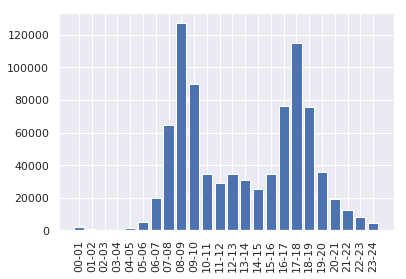

In [5]:
plt.bar(commuter_times["Time"], commuter_times["Total Trips"])
bar = plt.xticks(rotation='vertical')


It becomes abundantly clear that rush hour in the AM is between 7 and 10am, and between 4 - 7pm at night for start times. 

# Understanding the Most Popular Routes

In order for me to find commuter trips, I make each trip name a unique identifier which is marked by the concatenation of the start and end station. I believe it makes sense most to look at routes: Which is a roundtrip between two stations. **I am moving under the assumption that if someone is a commuter, they must go from home to work, and then back home.**

Two seperate queries are run -- one for morning and one for afternoon commuter trips.

In [6]:
# Query the 10 most popular trips with times for subscribers in AM
! bq query --use_legacy_sql=FALSE --format=csv -n 16000 'SELECT DISTINCT(CONCAT(start_station_name, end_station_name)) as trip_name, COUNT(*) as counts FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE Time(start_date) BETWEEN "07:00:00" AND "10:00:00" GROUP BY trip_name ORDER BY counts DESC' > popular_trips_AM.csv
popular_trips_AM = pd.read_csv('popular_trips_AM.csv')
popular_trips_AM['AM_rank'] = np.arange(len(popular_trips_AM)) + 1
popular_trips_AM.head()


Waiting on bqjob_r194972d1eae980c5_0000016d983e0f06_1 ... (0s) Current status: DONE   

,trip_name,counts,AM_rank
0,Harry Bridges Plaza (Ferry Building)2nd at Townsend,4556,1
1,Steuart at Market2nd at Townsend,3796,2
2,San Francisco Caltrain 2 (330 Townsend)Townsend at 7th,3548,3
3,San Francisco Caltrain (Townsend at 4th)Embarcadero at Folsom,3372,4
4,San Francisco Caltrain (Townsend at 4th)Temporary Transbay Terminal (Howard at Beale),3137,5


In [7]:
# Query the 10 most popular trips with times for subscribers in PM
# I switched up start and end station to compare the two tables
! bq query --use_legacy_sql=FALSE --format=csv -n 16000 'SELECT DISTINCT(CONCAT(end_station_name, start_station_name)) as trip_name, COUNT(*) as counts FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE Time(start_date) BETWEEN "16:00:00" AND "19:00:00" GROUP BY trip_name ORDER BY counts DESC' > popular_trips_PM.csv
popular_trips_PM = pd.read_csv('popular_trips_PM.csv')
popular_trips_PM['PM_rank'] = np.arange(len(popular_trips_PM)) + 1
popular_trips_PM.head()


Waiting on bqjob_r6b124bee8a86b14f_0000016d983e166f_1 ... (0s) Current status: DONE   

,trip_name,counts,PM_rank
0,Harry Bridges Plaza (Ferry Building)2nd at Townsend,4310,1
1,San Francisco Caltrain (Townsend at 4th)Embarcadero at Folsom,4067,2
2,Steuart at MarketEmbarcadero at Sansome,4031,3
3,San Francisco Caltrain (Townsend at 4th)Steuart at Market,3440,4
4,San Francisco Caltrain (Townsend at 4th)Temporary Transbay Terminal (Howard at Beale),3338,5


In [8]:
# Merge both DF to get a rank
total_rank = popular_trips_AM.merge(popular_trips_PM, on='trip_name', how='left')
total_rank['final_rank'] = (total_rank["AM_rank"] + total_rank["PM_rank"])/2
total_rank = total_rank.sort_values(by=["final_rank"], ascending=True)
total_rank['sum_counts'] = total_rank["counts_x"] + total_rank["counts_y"]
total_rank.head()



,trip_name,counts_x,AM_rank,counts_y,PM_rank,final_rank,sum_counts
0,Harry Bridges Plaza (Ferry Building)2nd at Townsend,4556,1,4310.0,1.0,1.0,8866.0
3,San Francisco Caltrain (Townsend at 4th)Embarcadero at Folsom,3372,4,4067.0,2.0,3.0,7439.0
4,San Francisco Caltrain (Townsend at 4th)Temporary Transbay Terminal (Howard at Beale),3137,5,3338.0,5.0,5.0,6475.0
2,San Francisco Caltrain 2 (330 Townsend)Townsend at 7th,3548,3,2911.0,8.0,5.5,6459.0
8,Steuart at MarketEmbarcadero at Sansome,2831,9,4031.0,3.0,6.0,6862.0


It is clear to see that the top 5 most popular trips are :

**1. Harry Bridges Plaza (Ferry Building) - 2nd at Townsend**	

**2. San Francisco Caltrain (Townsend at 4th) - Embarcadero at Folsom**

**3. San Francisco Caltrain (Townsend at 4th) - Temporary Transbay Terminal
(Howard at Beale)**

**4. San Francisco Caltrain 2 (330 Townsend) - Townsend at 7th**

**5. Steuart at Market - Embarcadero at Sansom**

As a sanity check, if you look at the sum_counts for these 5, they are the 5 highest.

# Reccomendation: Offer discounts are certain times

In [9]:
# Got this data from a similar query to what I did above, but changed customer type from subscriber to customer
# Query can be found in question #3 of part 2, where the only diff is that subscriber_type = "Customer
customer_times = pd.read_csv('customer_times.csv')
customer_times.head()



,Time,Total Trips
0,00-01,848
1,01-02,639
2,02-03,413
3,03-04,208
4,04-05,160


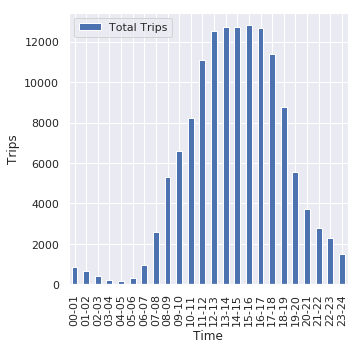

In [10]:
ax = customer_times.plot(kind='bar',x='Time',y='Total Trips', figsize=[5, 5])
ax.set_xlabel("Time",fontsize=12)
ax.set_ylabel("Trips",fontsize=12)
plt.show()


Note how unlike the subscribers which had a bimodal graph around rush hour, the customers ride the most around midday, between 12-5. **However, there is downtime before 8am and after 7pm. Thus, from 7pm - 8am, there should be discounted ride passes.** Much like Bird/Lime, Ford GoBike could offer a per minute usage cost which would be attractive to the user instead of paying a flat price. However, this would NOT be during the whole day. It should only be when ridership is on the low end. 

Let us see what happens when we combine the two graphs

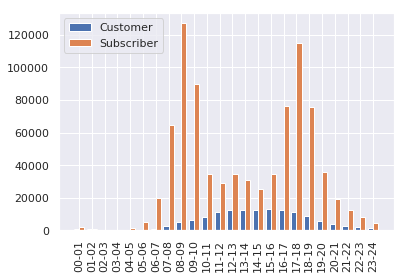

In [11]:
X = np.arange(len(customer_times["Time"]))
plt.bar(X  - .2, customer_times["Total Trips"], .4, label = 'time')
plt.bar(X  + .2, commuter_times["Total Trips"], .4, label = 'time')
plt.xticks(X, customer_times["Time"], rotation='vertical')
plt.legend(['Customer', 'Subscriber'])
plt.show()


Note how when we look at graphs indivdually, the scales seem similar. However when we combine, we can see that Subscribers engage in significantly more trips than Customers. **Thus, there could be an argument made to change the entire customer pricing from flat rate to variable pricing.** This would incentivize additional consumers to ride the bike without the fear of having only 30-minute or day options, which seem to be arbitrary.

#  Reccomendation: Offering discounts when going to lesser used stations

In [12]:
# How can we compare the least visited stations with the amount of docks they have
# Query dock counts
! bq query --use_legacy_sql=FALSE --format=csv -n 16000 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_stations` ORDER BY dockcount DESC' > dock_counts.csv
dock_counts = pd.read_csv('dock_counts.csv')
dock_counts.rename(columns={'name':'station'}, inplace=True)
station_names = dock_counts[['station', 'dockcount']]
station_names.head()
    

Waiting on bqjob_r5e3953fcaa17b37d_0000016d983e215a_1 ... (0s) Current status: DONE   

,station,dockcount
0,Cyril Magnin St at Ellis St,35
1,5th St at Folsom St,31
2,San Jose Diridon Caltrain Station,27
3,2nd at Townsend,27
4,Market at 10th,27


In [27]:

# Query the least "TO" stations by name and count
! bq query --use_legacy_sql=FALSE --format=csv -n 16000 'SELECT DISTINCT(end_station_name) as station, COUNT(*) as counts FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY station ORDER BY counts ASC' > least_to_station.csv
least_to_end_station = pd.read_csv('least_to_station.csv')
least_to_end_station.head()

Waiting on bqjob_r4eacf815233e0a7a_0000016d984b5130_1 ... (0s) Current status: DONE   

,station,counts
0,5th St at E. San Salvador St,1
1,Sequoia Hospital,14
2,San Jose Government Center,23
3,5th S at E. San Salvador St,24
4,Cyril Magnin St at Ellis St,68


In [28]:
# Query the least "FROM" stations by name and count
! bq query --use_legacy_sql=FALSE --format=csv -n 16000 'SELECT DISTINCT(start_station_name) as station, COUNT(*) as counts FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY station ORDER BY counts ASC' > least_from_station.csv
least_from_station = pd.read_csv('least_from_station.csv')
least_from_station.head()


Waiting on bqjob_r479af3f0920252e5_0000016d984b7c78_1 ... (0s) Current status: DONE   

,station,counts
0,5th St at E. San Salvador St,1
1,Sequoia Hospital,15
2,5th S at E. San Salvador St,19
3,San Jose Government Center,23
4,Middlefield Light Rail Station,66


In [26]:
# Combine start and end stations to see if there are stations that systematically get less visitors
merged_rank = least_to_start_station.merge(least_to_end_station, on='station', how='left')
merged_rank = merged_rank.merge(station_names, on='station', how='left')
merged_rank.rename(columns={'counts_x':'FROM'}, inplace=True)
merged_rank.rename(columns={'counts_y':'TO'}, inplace=True)

# Note how some of the stations have a NAN dockcount
# This means they are no longer in operation, even though they used to be
# We will now drop them
merged_rank = merged_rank.dropna()
merged_rank.head(5)



,station,FROM,TO,dockcount
4,Middlefield Light Rail Station,66,93,15.0
6,Cyril Magnin St at Ellis St,69,68,35.0
10,5th St at Folsom St,173,151,31.0
11,Franklin at Maple,226,264,15.0
12,Redwood City Public Library,272,344,15.0


We know that the stations above have the least amount of bikes going to and from these stations. **Thus, if a bike either starts or ends at these 5 locations above, the trips can be half off for customers. Moreover if a subscriber takes this route, they can be entered into a rewards program that would allow them to work towards discounts.**

This logic can be extended to any amount of stations in the bottom half, or those that have higher dockcounts (dockcounts DF is above)

# Infrastructure Reccomendation: How can you reallocate stations? (Bonus)

Note this section does not directly answer the question of offering deals throughout the day. However, this solution allows for something more fundamental to the company. One can imagine a scenario where they want to take a trip; however they cannot because there are simply no bikes available at the station, or docks open when they want to park. Thus I critque the question itsself: **Can you offer a deal without having your infrastructure in place correctly?**

In [16]:
# Drop NA, get an average count, see how many trips/per dock
merged_rank.head(10)
print(merged_rank['dockcount'].sum())
merged_rank['average_count'] = (merged_rank['counts_x']+merged_rank['counts_y'])/2

# We know the average trips for 1 dock should be 736 if we reallocated fairly
avg_dock_count = merged_rank['average_count'].sum()/merged_rank['dockcount'].sum()
print(avg_dock_count)

# Understand how many docks each station SHOULD have, and sort by how off they are
merged_rank['proposed_dock_count'] = round(merged_rank['counts_x']/avg_dock_count)
merged_rank['reallocation'] = merged_rank['proposed_dock_count'] - merged_rank['dockcount']
merged_rank = merged_rank.sort_values(by=["reallocation"], ascending=True)
merged_rank.head()

1306.0
736.0551301684533


,station,counts_x,counts_y,dockcount,average_count,proposed_dock_count,reallocation
6,Cyril Magnin St at Ellis St,69,68,35.0,68.5,0.0,-35.0
10,5th St at Folsom St,173,151,31.0,162.0,0.0,-31.0
32,Redwood City Caltrain Station,2249,1870,25.0,2059.5,3.0,-22.0
36,San Antonio Caltrain Station,2601,2621,23.0,2611.0,4.0,-19.0
43,Palo Alto Caltrain Station,3281,2847,23.0,3064.0,4.0,-19.0


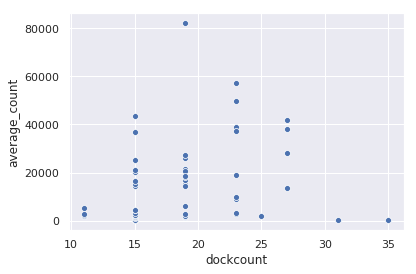

In [17]:
sns.scatterplot('dockcount', 'average_count', data=merged_rank)

Here we see a scatter plot of the average amount of trips to/from a station, vs the amount of docks. Ideally, we should have a positive linear relationship between the two values. However, this is clearly not the case. The next part shows us how we should reallocate the docks. 

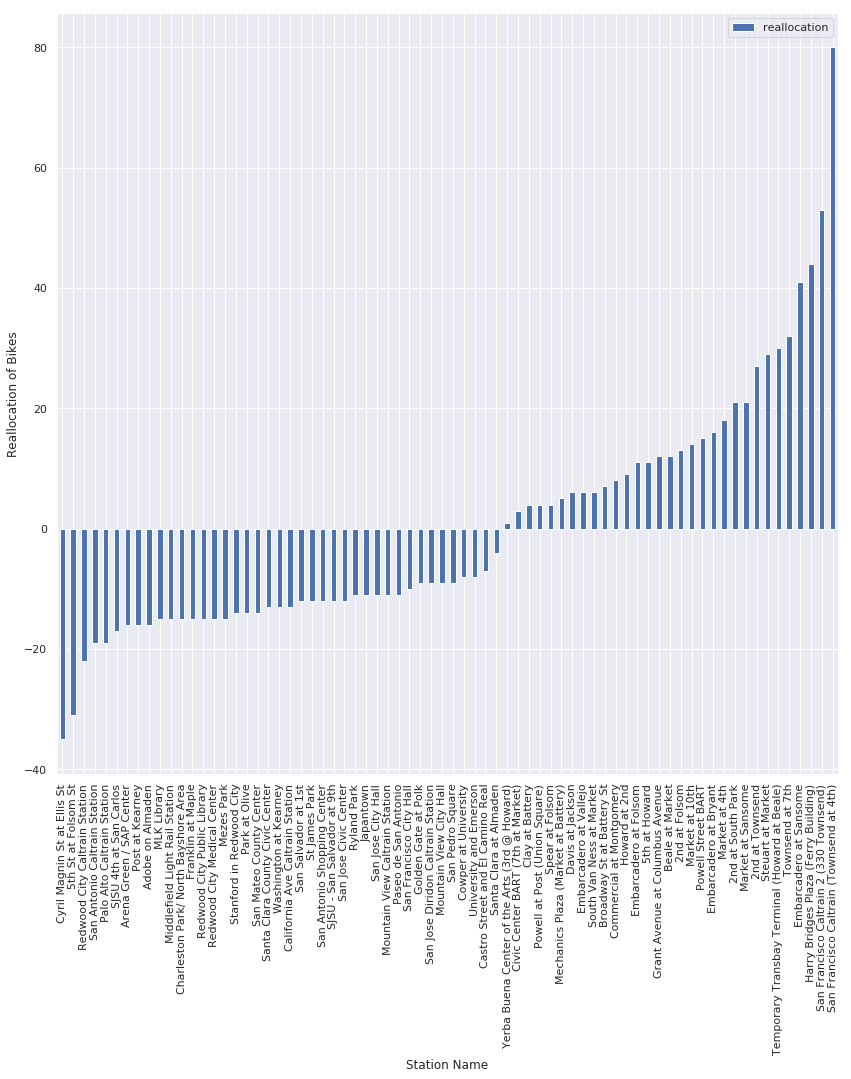

In [18]:
ax = merged_rank.plot(kind='bar',x='station',y='reallocation', figsize=[14, 14])
ax.set_xlabel("Station Name",fontsize=12)
ax.set_ylabel("Reallocation of Bikes",fontsize=12)
plt.show()

We can see how the bikes stations should be reallocated. There was no information given about additional funding for new stations. Thus I assume the only way to get bikes is to reallocate them. In order to maximize trips, stations that should have the most bikes taken away are: Cyril Magnin St at Ellis St, 5th St at Folsom St, and Redwood City Caltrain Station. On the other hand, Harry Bridges Plaza (Ferry Building), San Francisco Caltrain 2 (330 Townsennd), and San Francisco Caltrain (Townsend at 4th)	need the most additions.